In [1]:
from bs4 import BeautifulSoup
import numpy as np
import pprint as pp
import urllib
import os
import json


def duplicate_deleter(path):
    """ Deletes all duplicate html files in the specifeid path"""
    files = [f for f in os.listdir(path) if '.html' in f]
    for file in files:
        if '(' and ')' in file:
            os.remove(os.path.join(path,file))

def data_getter(account_soup):
    """ Takes account soup and gets the username, 
    then the number of likes, photos, videos, audios and subscriber price."""
    soup = account_soup
    out_dict = {}
    # get username
    username_soup = soup.find('a',class_="g-user-realname__wrapper")# get username
    if username_soup is None:
        return ''
    handle = username_soup.contents[1].string # username with '@'
    username = handle[2:-1] # removes spaces at end
    out_dict['username'] = username
    #get numbers
    href_index = '/'+username+'/' # create index for all stuff

    search_elements = ('likes','photos','videos','audios')
    for elem in search_elements:
        href1 = href_index + elem
        soup1 = soup.find('a',href=href1)
        if soup1 is None:
            output = '0'
        else:
            output=soup1.contents[0].string
        out_dict[elem] = output
    # get subscription price
    sub_class = 'm-fluid-width m-with-icon m-subscribe-btn m-rounded m-border m-profile dark g-btn'
    if soup.find('div',class_=sub_class) is None:
        out_dict['sub_price'] = 'Not found'
    else:
        out_dict['sub_price'] = soup.find('div',class_=sub_class).contents[1].contents[0][:-1].split('$')[-1]
    
    # get "last seen" date
    sub_class_2 = 'b-profile__user__status__text'
    if soup.find('div',class_=sub_class_2) is None or len(list(soup.find('div',class_=sub_class_2))) < 2:
        out_dict['last_seen'] = 'Not found'
    else:
        out_dict['last_seen'] = str(soup.find('div',class_=sub_class_2).contents[1]).split('"')[1]
    
    # if number of fans is public, get it
    fans_sub_class = 'b-profile__actions__item'
    if soup.find('li',class_=fans_sub_class) is None:
        out_dict['num_fans'] = 'Not found'
    else:
    
        for item in soup.find_all('li',class_=fans_sub_class):
            if 'Fans' in str(item.contents[0]):
                out_dict['num_fans'] = str(item).split('"b-profile__actions__count">')[1].split('<')[0]
    
    return out_dict


# Get info from the scrapes
path = r'/Users/Thomas/Projects/Learning data science/Onlyfans data/scrapes'
# delete duplicates
duplicate_deleter(path)
# get account list
out_list = []
account_list = [f for f in os.listdir(path) if '.html' in f]
for account in account_list:
    path_2 = os.path.join(path,account)
    soup = BeautifulSoup(open(path_2),'html.parser')
    out_dict = data_getter(soup)
    out_list.append(out_dict)

# save file
save_path = r'/Users/Thomas/Projects/Learning data science/Onlyfans data/scraped_data.json'
with open(save_path, 'w') as fout:
    json.dump(out_list , fout)

In [2]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [17]:
import pandas as pd 
keys_list = ['audios','last_seen','likes','num_fans','photos','sub_price','username','videos']
onlyfans = pd.DataFrame(out_list,columns=keys_list)
onlyfans.head()

onlyfans.describe()

,audios,last_seen,likes,num_fans,photos,sub_price,username,videos
count,801,801,801,122,801,801,801,801
unique,17,400,429,69,522,67,801,354
top,0,Not found,0,Not found,0,Not found,lexi_lluv,0
freq,727,292,86,48,68,351,1,108


In [19]:
# format the numbers in the dataframe
onlyfans['likes'] = onlyfans['likes'].astype(str,errors='ignore').str.replace('K','e3').astype(float,errors='ignore')
onlyfans['photos'] = onlyfans['photos'].astype(float,errors='ignore')
onlyfans['audios'] = onlyfans['audios'].astype(float,errors='ignore')
onlyfans['videos'] = onlyfans['videos'].astype(float,errors='ignore')
onlyfans['num_fans'] = pd.to_numeric(onlyfans['num_fans'],errors='coerce')
#onlyfans['sub_price'] = onlyfans['sub_price'].map({'Not found': 'NaN'},na_action='ignore')
onlyfans['sub_price'] = pd.to_numeric(onlyfans['sub_price'],errors='coerce')
onlyfans.describe()

,audios,likes,num_fans,sub_price,videos
count,801.000000,801.000000,71.000000,438.000000,801.000000
mean,0.520599,13284.583021,772.112676,11.783402,169.423221
std,3.188634,37325.105583,1742.633217,7.048244,254.231158
min,0.000000,0.000000,2.000000,4.990000,0.000000
25%,0.000000,170.000000,58.000000,7.000000,17.000000
50%,0.000000,2600.000000,157.000000,9.990000,88.000000
75%,0.000000,11300.000000,625.000000,13.990000,232.000000
max,58.000000,539800.000000,12125.000000,50.000000,2363.000000


Text(0.5,1,'Histogram of number of likes per OnlyFans account')

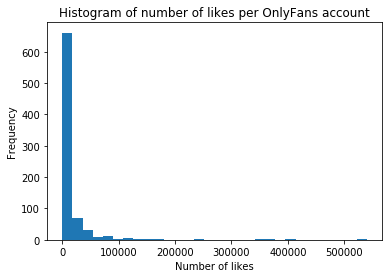

In [20]:
onlyfans['likes'].dropna().plot(kind='hist',bins=30)
plt.xlabel('Number of likes')
plt.title('Histogram of number of likes per OnlyFans account')

Text(0.5,1,'Histogram of subscription price for OnlyFans accounts')

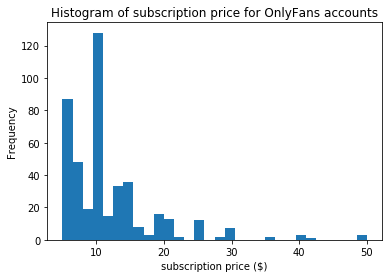

In [21]:
onlyfans['sub_price'].dropna().plot(kind='hist',bins=30)
plt.xlabel('subscription price ($)')
plt.title('Histogram of subscription price for OnlyFans accounts')
# sub price is pretty consistent

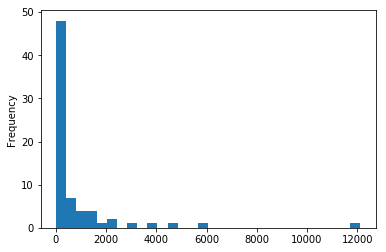

In [22]:
onlyfans['num_fans'].dropna().plot(kind='hist',bins=30)
# number of fans if posted

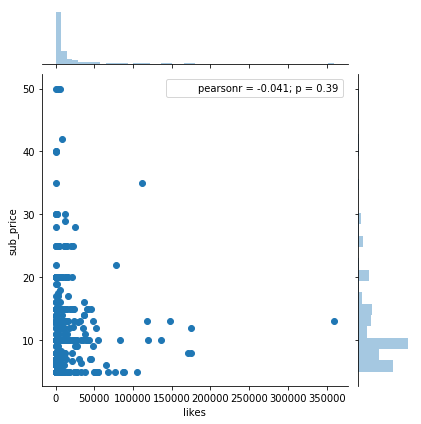

In [23]:
sns.jointplot(data=onlyfans,x='likes',y='sub_price',kind='scatter')

In [42]:
# get number of likes per post
onlyfans['num_posts'] = onlyfans[['videos','audios','photos']].sum(axis=1)
onlyfans['likes_per_post'] = onlyfans['likes'] / onlyfans['num_posts'].astype(float,errors='ignore')
onlyfans['likes_per_post'] = onlyfans['likes_per_post'].replace([np.inf, -np.inf], 0)
onlyfans['likes_per_post'] = onlyfans['likes_per_post'].fillna(0)
onlyfans.describe()

,audios,likes,num_fans,sub_price,videos,num_posts,likes_per_post,revenue
count,801.000000,801.000000,729.000000,803.000000,801.000000,803.000000,803.000000,729.000000
mean,0.520599,13284.583021,179.754458,8.695492,169.423221,169.520548,102.872241,1256.786612
std,3.188634,37325.105583,828.696927,6.206874,254.231158,254.919718,573.297312,4616.222775
min,0.000000,0.000000,0.000000,4.990000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,170.000000,10.000000,4.990000,17.000000,17.000000,4.165669,64.870000
50%,0.000000,2600.000000,30.000000,4.990000,88.000000,88.000000,22.513089,214.570000
75%,0.000000,11300.000000,99.000000,10.000000,232.000000,232.000000,68.713041,825.000000
max,58.000000,539800.000000,12400.000000,50.000000,2363.000000,2363.000000,12400.000000,61876.000000


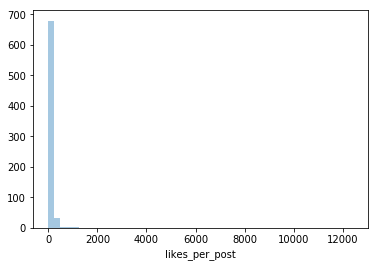

In [30]:
sns.distplot(onlyfans['likes_per_post'].dropna(),kde=False,)
# plot number of likes per post

In [11]:
# jem wolfe
onlyfans[onlyfans['likes'] == onlyfans['likes'].max()]

,audios,last_seen,likes,num_fans,photos,sub_price,username,videos,num_posts,likes_per_post
13,0.0,"Apr 6, 3:13 pm",539800.0,NaN,203,NaN,jemwolfie,78.0,78.0,6920.512821


In [43]:
# if number of fans is nan, replace with avg likes per post
onlyfans['num_fans'] = onlyfans['num_fans'].fillna(onlyfans['likes_per_post'],axis=0)
onlyfans['num_fans'] = onlyfans['num_fans'].apply(np.round)
onlyfans['num_fans'].replace(0.0,np.nan)

# if sub-price is nan replace with minimum
onlyfans['sub_price'] = onlyfans['sub_price'].fillna(4.99,axis=0)

onlyfans.describe()

,audios,likes,num_fans,sub_price,videos,num_posts,likes_per_post,revenue
count,801.000000,801.000000,803.000000,803.000000,801.000000,803.000000,803.000000,729.000000
mean,0.520599,13284.583021,163.189290,8.695492,169.423221,169.520548,102.872241,1256.786612
std,3.188634,37325.105583,791.252373,6.206874,254.231158,254.919718,573.297312,4616.222775
min,0.000000,0.000000,0.000000,4.990000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,170.000000,5.000000,4.990000,17.000000,17.000000,4.165669,64.870000
50%,0.000000,2600.000000,26.000000,4.990000,88.000000,88.000000,22.513089,214.570000
75%,0.000000,11300.000000,86.000000,10.000000,232.000000,232.000000,68.713041,825.000000
max,58.000000,539800.000000,12400.000000,50.000000,2363.000000,2363.000000,12400.000000,61876.000000


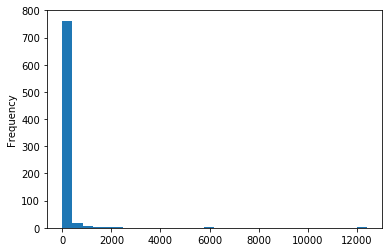

In [44]:
onlyfans['num_fans'].dropna().plot(kind='hist',bins=30)

count      803.000000
mean      1140.968169
std       4413.117746
min          0.000000
25%         34.930000
50%        179.820000
75%        728.355000
max      61876.000000
Name: revenue, dtype: float64

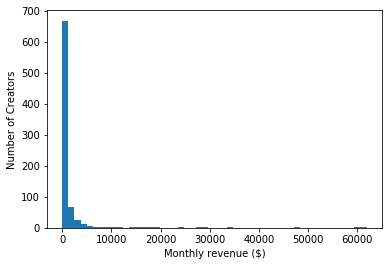

In [53]:
# monthly revenue
onlyfans['revenue'] = onlyfans['sub_price'] * onlyfans['num_fans']
onlyfans['revenue'].dropna().plot(kind='hist',bins=50)
plt.xlabel('Monthly revenue ($)')
plt.ylabel('Number of Creators')
onlyfans['revenue'].describe()

In [35]:
# how much is jem wolfe making per month?
#onlyfans['revenue'].value_counts()

In [50]:
# what percentaige of revenue is top account?
total_rev = onlyfans['revenue'].sum()
num_acc = onlyfans['revenue'].count()
max_rev = onlyfans['revenue'].max()
top_10p = onlyfans['revenue'].nlargest(int(np.floor(onlyfans['revenue'].count()*0.10))).sum()
top_1p = onlyfans['revenue'].nlargest(int(np.floor(onlyfans['revenue'].count()*0.01))).sum()
top_20p = onlyfans['revenue'].nlargest(int(np.floor(onlyfans['revenue'].count()*0.2))).sum()
print(max_rev/total_rev)
print('top 10%:', top_10p/total_rev)
print('top 1%:', top_1p/total_rev)
print('top 20%:',top_20p/total_rev)
# top 10% make 73% of the total revenue
# top 1% makes 34% of total revenue

0.06753566130898599
top 10%: 0.7331723607522851
top 1%: 0.33232371834612423
top 20%: 0.8576054960380592


count      803.000000
mean      1140.968169
std       4413.117746
min          0.000000
25%         34.930000
50%        179.820000
75%        728.355000
max      61876.000000
Name: revenue, dtype: float64


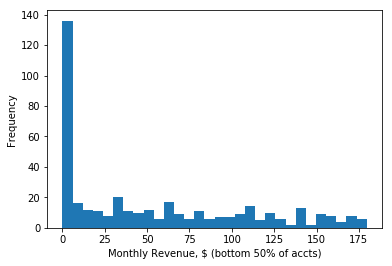

In [51]:
onlyfans['revenue'].nsmallest(int(np.floor(onlyfans['revenue'].count()*0.5))).plot(kind='hist',bins=30)
#plt.style.use('viridis')
plt.xlabel('Monthly Revenue, $ (bottom 50% of accts)')
print(onlyfans['revenue'].describe())

In [52]:
def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq: http://www.statsdirect.com/help/content/image/stat0206_wmf.gif
    # from: http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    array = array.flatten() #all values are treated equally, arrays must be 1d
    if np.amin(array) < 0:
        array -= np.amin(array) #values cannot be negative
    array += 0.0000001 #values cannot be 0
    array = np.sort(array) #values must be sorted
    index = np.arange(1,array.shape[0]+1) #index per array element
    n = array.shape[0]#number of array elements
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array))) #Gini coefficient

print(gini(np.array(onlyfans['revenue'].dropna())))
# gini coefficient of 0.89

0.8288172454278665


In [40]:
# get total revenue of onlyfans
n_creators = 30000 # half of stated in https://thewest.com.au/news/wa/wa-model-jem-wolfie-breaks-social-media-makes-millions-on-onlyfans-ng-b881158181z?fbclid=IwAR3ALMztvknNbHKdY7_pHWc9SwNTOfUjTbKKxdncIJZCa4o3JqMINZptHao
rev_per_creator = onlyfans['revenue'].mean() * 0.2
total_rev_month = n_creators * rev_per_creator
total_rev = total_rev_month * 12
print('Top-down estimate of yearly revenue is:',total_rev / 1000000)
print(rev_per_creator)
# bottom up calc
n_paying_users = 5e6 # half of 10m users, extrapolated from https://thewest.com.au/news/wa/wa-model-jem-wolfie-breaks-social-media-makes-millions-on-onlyfans-ng-b881158181z?fbclid=IwAR3ALMztvknNbHKdY7_pHWc9SwNTOfUjTbKKxdncIJZCa4o3JqMINZptHao
mean_sub_price = onlyfans['sub_price'].mean() # about $8.5 a month
print(mean_sub_price)
monthly_rev = mean_sub_price*n_paying_users * 0.2
yearly_rev = 12 * monthly_rev
print('Bottom up estimate of Yearly Revenue is: ',yearly_rev / 1e6)

Top-down estimate of yearly revenue is: 90.48863604938269
251.35732235939633
8.6954919053548
Bottom up estimate of Yearly Revenue is:  104.34590286425761


# Below is legacy code

In [ ]:
"""
In pseudocode:
Sikuli scraping dumps account html files into 'scrapes' folder
This script will:
1. delete all duplicate accounts in the 'scrapes' folder
2. for each account:
3. extract the number of posts, number of likes, number of videos, price to subscribe and subscribers (if poss)
4. save this in a dictionary indexed by account name
"""

In [61]:
# This test code now runs
path = r'/Users/Thomas/Projects/Learning data science/Onlyfans data/scrapes'
test_accounts = [r'_test_✨NoelleEaston✨---Onlyfans.html',r'_test_Abi-Monroe---Onlyfans.html','_test_Adrenalynn-TOAO---Onlyfans.html']
out_list = []
for account in test_accounts:
    path_2 = os.path.join(path,account)
    soup = BeautifulSoup(open(path_2),'html.parser')
    out_dict = data_getter(soup)
    out_list.append(out_dict)
print(out_list)

[{'username': 'noelleeaston', 'likes': '14.3K', 'photos': '1034', 'videos': '301', 'audios': '4', 'sub_price': '9.99', 'last_seen': 'Not found', 'num_fans': '157'}, {'username': 'abi_monroe', 'likes': '625', 'photos': '48', 'videos': '2', 'audios': '0', 'sub_price': 'Not found', 'last_seen': 'Sep 13, 3:23 pm'}, {'username': 'adrenalynntoao', 'likes': '9.1K', 'photos': '833', 'videos': '160', 'audios': '0', 'sub_price': '7.95', 'last_seen': 'Mar 20, 6:30 pm'}]


In [42]:
# test this out first
path = r'/Users/Thomas/Projects/Learning data science/Onlyfans data/scrapes'
test_account = '_test_🌿-Shawna-🌿---Onlyfans.html'
path_to_account = os.path.join(path,test_account)
soup = BeautifulSoup(open(path_to_account),'html.parser')

# get account username
username_soup = soup.find('a',class_="g-user-realname__wrapper")# get username
handle = username_soup.contents[1].string # username with '@'
username = handle[2:-1] # removes spaces at end
print('Username is: ',username)

# get numbers
href_index = '/'+username+'/' # create index for all stuff

search_elements = ('likes','photos','videos','audios')
out_dict = {}
for elem in search_elements:
    href1 = href_index + elem
    soup1 = soup.find('a',href=href1)
    if soup1 is None:
        output = '0'
    else:
        output=soup1.contents[0].string
    out_dict[elem] = output
# get subscription price
sub_class = 'm-fluid-width m-with-icon m-subscribe-btn m-rounded m-border m-profile dark g-btn'
out_dict['sub_price'] = soup.find('div',class_=sub_class).contents[1].contents[0][:-1].split('$')[-1]
out_dict['username'] = username
# get last seen
sub_class_2 = 'b-profile__user__status__text'
if soup.find('div',class_=sub_class_2) is None:
    out_dict['last_seen'] = 'Not found'
else:
    out_dict['last_seen'] = soup.find('div',class_=sub_class_2).contents

# get num fans
fans_sub_class = 'b-profile__actions__item'
if soup.find('li',class_=fans_sub_class) is None:
    out_dict['num_fans'] = 'Not found'

for item in soup.find_all('li',class_=fans_sub_class):
    if 'Fans' in str(item.contents[0]):
        out_dict['num_fans'] = str(item).split('"b-profile__actions__count">')[1].split('<')[0]

Username is:  shawnalenee
222


In [ ]:
#legacy code
# get likes
href_likes = href_index + 'likes'
likes_soup = soup.find('a',href=href_likes)
likes = likes_soup.contents[0].string
# get photos
href_photos = href_index + 'photos'
photos_soup = soup.find('a',href=href_photos)
photos=photos_soup.contents[0].string
# get videos
href_videos = href_index + 'videos'
videos_soup = soup.find('a',href=href_videos)
videos=videos_soup.contents[0].string
videos

In [ ]:
""" Next step is to write a cleaning script which deletes all the duplicates 
Pseudo code
1. for list of files
if there are any numbers in brackets (#)
delete those files"""

In [90]:
# run this to delete duplicates

path = r'/Users/Thomas/Projects/Learning data science/Onlyfans data/scrapes'
files = [f for f in os.listdir(path) if '.html' in f]
# get list of duplicates
delete_list = []
for file in files:
    if '(' and ')' in file:
        os.remove(os.path.join(path,file))

In [1]:
onlyfans.describe()

NameError: name 'onlyfans' is not defined